In [61]:

from termcolor import colored
import numpy as np
from math import sqrt
from sklearn import datasets, linear_model,ensemble, tree, metrics
from pprint import pprint
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split, KFold
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carga de datos.
dataset = datasets.fetch_california_housing()
X = dataset.data
y = dataset.target
print(np.shape(X))

(20640, 8)


In [3]:
# Métricas de evaluación.
metricas = {
  'MAE':  'neg_mean_absolute_error',
  'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(metrics.mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False),
  'R2':   'r2',}

### 1) PARTICIÓN EXTERNA DE DATOS

In [4]:
# 1) Partición de datos externa
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_training))
print(np.shape(X_testing))

(16512, 8)
(4128, 8)


### 2-5) ENTRENAMIENTO

In [5]:
# 2) Extracción de características
# 3) Selección de atributos

In [6]:
# 4) Estandarización de los datos de entrenamiento
standardizer = preprocessing.StandardScaler()
X_stdr = standardizer.fit_transform(X_training)

In [7]:
# 5) Construcción del algoritmo de aprendizaje.
k = 10

knn = KNeighborsRegressor(n_neighbors = k, weights='distance', metric='euclidean')

In [8]:
# 5.1) Validación cruzada interna

# Extraer MEAN +- STD del coeficiente de determinación (R2) para un cross validation de 5 bolsas aleatorias y semilla en 42
r2_cv_results = cross_validate( knn, X_stdr ,y_training,
                               cv= KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)

print("cross_val_R2:   %0.4f +/- %0.4f" % (r2_cv_results['test_R2'].mean(), r2_cv_results['test_R2'].std()))

cross_val_R2:   0.6962 +/- 0.0096


In [9]:
# Extraer métricas MAE, MSE, RMSE y MAPE en un cross validation para 5 bolsas aleatorias y semilla en 42
metrics_cv_results = cross_validate( knn, X_stdr ,y_training,
                               cv= KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)

pprint(metrics_cv_results)

{'fit_time': array([0.03827453, 0.01562548, 0.0156219 , 0.01563454, 0.01641273]),
 'score_time': array([0.17215323, 0.33881664, 0.26562476, 0.43968105, 0.42286682]),
 'test_MAE': array([-0.45508636, -0.43747382, -0.42656226, -0.43984405, -0.43381931]),
 'test_MAPE': array([-24.61909207, -23.96339877, -23.97232907, -24.28066021,
       -23.49003617]),
 'test_R2': array([0.69060555, 0.69611085, 0.71414633, 0.68628936, 0.69379863]),
 'test_RMSE': array([-0.65342222, -0.63534593, -0.61742286, -0.65008873, -0.62943728])}


In [10]:
# Extraer las predicciones del cross validation de 5 bolsas aleatorias y semilla en 42
y_pred= cross_val_predict(knn , X_stdr, y_training,cv= KFold(n_splits=5, shuffle=True, random_state=42))


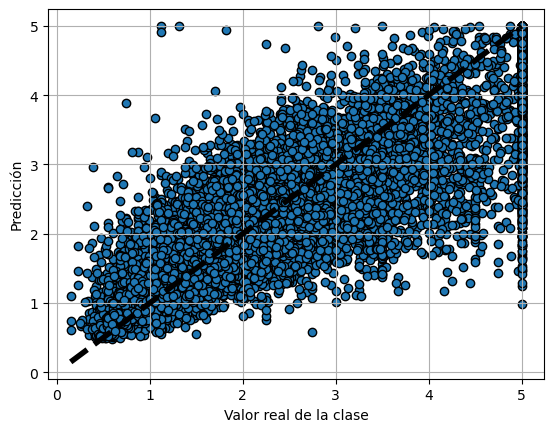

In [11]:
# Crear una función que dadas las variables "y" e "y_pred" se visualice la bisectriz
def plot_bisectriz(y, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.grid()
    plt.show()

# Visualiza la bisetriz
plot_bisectriz(y_training , y_pred)

In [12]:
# 5.2) Entrenamiento del modelo definitivo
model = knn.fit(X_stdr, y_training)

### 6-10) PREDICCIÓN

In [13]:
# 6) Extracción de las características de test
# 7) Selección de los atributos de test 

In [14]:
# 8) Estandarización de las característiacs de test
X_test_stdr = standardizer.transform(X_testing)

In [15]:
# 9) Predicción del conjunto de test
y_pred_test = model.predict(X_test_stdr)

MAE:  0.4368
MSE: 0.4163
RMSE: 0.6452
R2:   0.6823


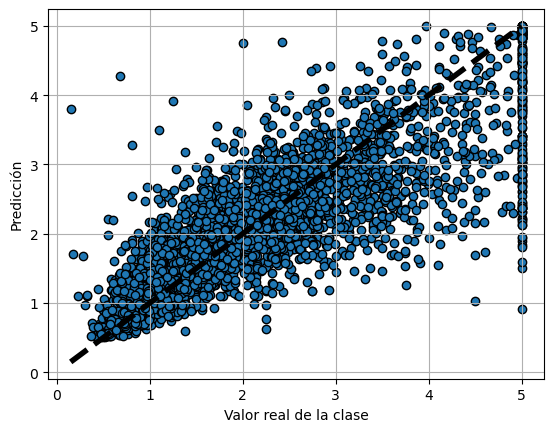

In [16]:
# 10) Evaluación del modelo sobre el conjunto de test
MAE = metrics.mean_absolute_error(y_testing, y_pred_test)
MSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=True)
RMSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=False)
R2 = metrics.r2_score(y_testing, y_pred_test)

print('MAE:  %.4f' % MAE)
print('MSE: %.4f' % MSE)
print('RMSE: %.4f' % RMSE)
print('R2:   %.4f' % R2)

# Visualización de resultados
plot_bisectriz(y_testing, y_pred_test)

### ACTIVIDAD EXTRA

#### Entrenar el mejor modelo posible con el algoritmo KNN y comparar el resultado con el modelo OLS en test

In [17]:
from sklearn.model_selection import GridSearchCV

In [ ]:

# Definir parámetros de búsqueda
parameters = {'n_neighbors':range(2,7), 
              'weights':('uniform', 'distance'), 
              'metric': ('minkowski', 'euclidean', 'manhattan'), 
              'algorithm': ('ball_tree', 'kd_tree', 'auto')}

# Aplicar el algoritmo de búsqueda
knn = KNeighborsRegressor()
model = GridSearchCV(knn, parameters, scoring='r2')

# Entrenar el modelo
model.fit(X_stdr, y_training)

# Extraer los mejores parámetros
model.best_params_

In [62]:
# Entrenar cada algoritmo y comparar los resultados (a nivel cuantitativo y cualitativo) sobre el conjunto de test
parameters = {'OLS': {'positive': (True, False)},
              'Lasso': {'alpha': (0.1, 1, 5, 10, 50, 100)},
              'Ridge': {'alpha': (0.1, 1, 5, 10, 50, 100)},
              'RANSAC': {'base_estimator':([linear_model.LinearRegression(),tree.DecisionTreeRegressor(),ensemble.RandomForestRegressor()]),
                         'min_samples':([2, 3, 5]),
                         'residual_threshold':(0.5,1,1.5),
                        'max_trials':([4,5,6]),
                         'loss':(['absolute_error'])},
              'KNN': {'n_neighbors':range(2,7),
                      'weights':('uniform', 'distance'),
                      'metric': ('minkowski', 'euclidean', 'manhattan'),
                      'algorithm': ('ball_tree', 'kd_tree', 'auto')}}

In [63]:
algs = {'OLS': linear_model.LinearRegression(),
        'Lasso': linear_model.Lasso(random_state=42),
        'Ridge': linear_model.Ridge(random_state=42),
        'RANSAC': linear_model.RANSACRegressor(),
        'KNN': KNeighborsRegressor(),
        }

In [64]:
model = {}
for name, _ in algs.items():
    print(colored('Algorithm: ' + name, 'red'))
    score = make_scorer(r2_score)
    model_cv = GridSearchCV(algs[name], parameters[name], scoring=score, cv=5, return_train_score=True)
    model[name] = model_cv.fit(X_stdr, y_training)
    cv_res = model[name].cv_results_
    print('Best parameters: ', model[name].best_params_)
    best_iter = model[name].best_index_
    print('R2 score: %0.4f +/- %0.4f' % (cv_res['mean_test_score'][best_iter], cv_res['std_test_score'][best_iter]))
    print('------------')

Algorithm: OLS
Best parameters:  {'positive': False}
R2 score: 0.6115 +/- 0.0065
------------
Algorithm: Lasso
Best parameters:  {'alpha': 0.1}
R2 score: 0.4971 +/- 0.0041
------------
Algorithm: Ridge
Best parameters:  {'alpha': 0.1}
R2 score: 0.6115 +/- 0.0065
------------
Algorithm: RANSAC
Best parameters:  {'base_estimator': RandomForestRegressor(), 'loss': 'absolute_error', 'max_trials': 6, 'min_samples': 5, 'residual_threshold': 1.5}
R2 score: 0.6998 +/- 0.0349
------------
Algorithm: KNN
Best parameters:  {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
R2 score: 0.7273 +/- 0.0041
------------
